## Performance on reconstructed images

In [1]:
import pandas as pd
import numpy as np
import os, cv2, random, pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader
import statistics

size = 224

/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
#create import function 
def image_import (img_path, class_type, appended_list):
    for i in os.listdir(img_path):
        read_path = os.path.join(img_path, i)
       # print(i)
        try:
            img = cv2.imread(read_path)
            img = cv2.resize(img, (size, size))
            appended_list.append([img, class_type])
        except Exception as e:
            print(f'Image error: {i}')
            pass



In [6]:
# create evaluation function
def evaluate_model_reconst_images(run_id,model,test_features,test_targets,name_figure):
    # run params
    section = 'vae'
    data_name = 'x-ray_old'
    RUN_FOLDER = 'run/{}/'.format(section)
    RUN_FOLDER += '_'.join([run_id, data_name])

    vae = load_model(VariationalAutoencoder, RUN_FOLDER)
    z_points = vae.encoder.predict(test_features)

    reconst_images = vae.decoder.predict(z_points)
    #model = tf.keras.models.load_model('pneumonia_cnn.model')
    result = model.predict_classes(reconst_images)
    accuracy = model.evaluate(reconst_images,test_targets)[1]
    #confusion matrix calculation
    false_negative = 0
    false_positive = 0
    true_negative = 0
    true_positive = 0
    for i in range(len(reconst_images)):
        if test_targets[i] == 1:
            if result[i] == 1:
                true_positive += 1
            elif result[i] == 0: 
                false_negative += 1
            else:
                print('error class not found')
        if test_targets[i] == 0:
            if result[i] == 1:
                false_positive += 1
            elif result[i] == 0: 
                true_negative += 1
            else:
                print('error class not found')
    test_result = [false_negative,
                   true_negative,
                   true_positive,
                   false_positive]
    adjusted_test_result = np.array(test_result)/(len(test_features))
    df_test_result = pd.DataFrame(np.array(['false_negative','true_negative','true_positive','false_positive']),columns=['results'])
    df_test_result['percent'] = adjusted_test_result
    df_test_result
    #confusion matrix plot 
    fig,ax = plt.subplots()
    heatmap = ax.pcolor((df_test_result['percent'].to_numpy().reshape(2,2)),cmap='Blues')
    data = df_test_result['percent'].to_numpy().reshape(2,2)* 100
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.text(x + 0.5, y + 0.5, '%.2f' % data[y, x],
                    horizontalalignment='center',
                    verticalalignment='center',
                    )
    ax.set_xticks([0.5,1.5])
    ax.set_yticks([0.5,1.5])
    ax.set_xticklabels(['Positive','Negative'])
    ax.set_yticklabels(['Negative','Positive'])
    plt.xlabel('actual value')
    plt.ylabel('predicted value')
    plt.title('Normalized pneumonia CNN confusion matrix with %.2f' %(accuracy*100)+ '% accuracy')
    plt.savefig(name_figure)
    plt.show()
    return false_negative,false_positive,true_negative,true_positive,accuracy


In [4]:
def multiple_running_evaluation_reconst_images(run_id,model,test_features,test_targets,num_runs):
    false_negative=[0 for x in range(num_runs)]
    false_positive=[0 for x in range(num_runs)]
    true_negative=[0 for x in range(num_runs)]
    true_positive=[0 for x in range(num_runs)]
    accuracy=[0 for x in range(num_runs)]
    for i in range(num_runs):
        j=i+1
        print(j)
        name_figure='accuracy_model_reconst_images_{}_{}.png'.format(run_id,j)
        false_negative[i],false_positive[i],true_negative[i],true_positive[i],accuracy[i]=evaluate_model_reconst_images(run_id,model,test_features,test_targets,name_figure)
    return false_negative,false_positive,true_negative,true_positive,accuracy

In [5]:
# load data
#import pneumonia testng data
img_path = 'data/X-ray_dataset_old/chest_xray/test/PNEUMONIA'
testing_data=[]
image_import(img_path, 1, testing_data)

#import normal lung testing data
img_path = 'data/X-ray_dataset_old/chest_xray/test/NORMAL'
image_import(img_path,0, testing_data)

#shuffle training_data
random.shuffle(testing_data)
#seperate testing to XY
test_features = []
test_targets = []

for f, t in testing_data:
    test_features.append(f)
    test_targets.append(t)

test_features = np.array(test_features).reshape(-1, size, size, 3)
test_targets = np.array(test_targets)   
test_features = test_features/255
model = tf.keras.models.load_model('pneumonia_cnn.model')



W1220 15:03:02.451987 140172893783872 deprecation.py:506] From /home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1220 15:03:02.452824 140172893783872 deprecation.py:506] From /home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1220 15:03:02.453399 140172893783872 deprecation.py:506] From /home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.pyt

W1220 15:07:03.389236 140172893783872 deprecation_wrapper.py:119] From /home/chiara/anaconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1220 15:07:03.392268 140172893783872 deprecation_wrapper.py:119] From /home/chiara/anaconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1220 15:07:03.403499 140172893783872 deprecation_wrapper.py:119] From /home/chiara/anaconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1220 15:07:03.415613 140172893783872 deprecation_wrapper.py:119] From /home/chiara/anaconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_defau

1
624/624 [==============================] - 3s 5ms/sample - loss: 0.8734 - acc: 0.7179


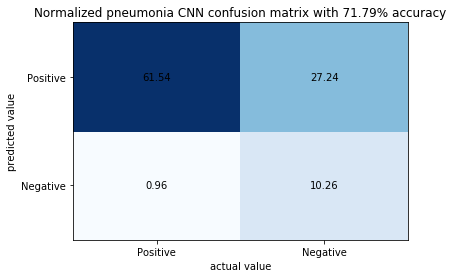

2
624/624 [==============================] - 4s 6ms/sample - loss: 0.7672 - acc: 0.7244


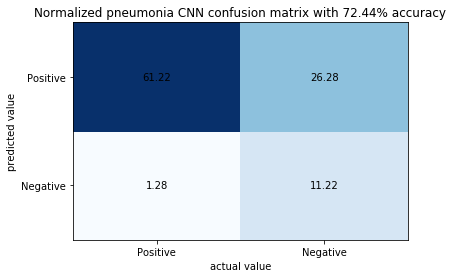

3
624/624 [==============================] - 4s 6ms/sample - loss: 0.8594 - acc: 0.7276


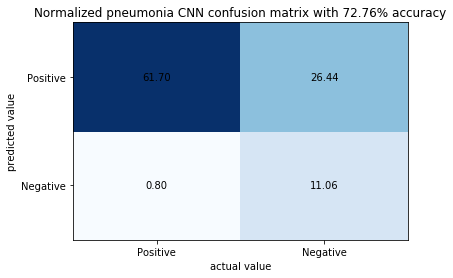

4
624/624 [==============================] - 5s 8ms/sample - loss: 0.8250 - acc: 0.7115


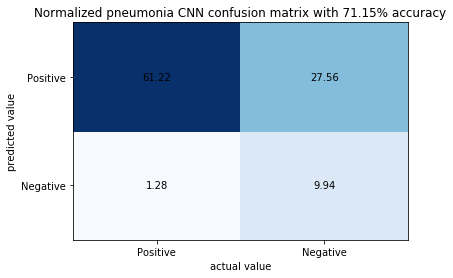

5
624/624 [==============================] - 5s 7ms/sample - loss: 0.8491 - acc: 0.7099


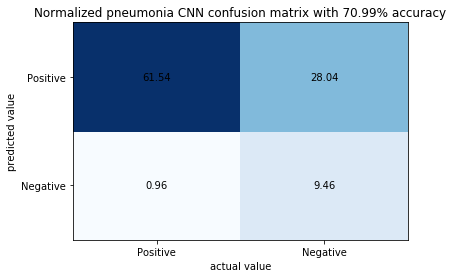

6
624/624 [==============================] - 5s 8ms/sample - loss: 0.8674 - acc: 0.7131


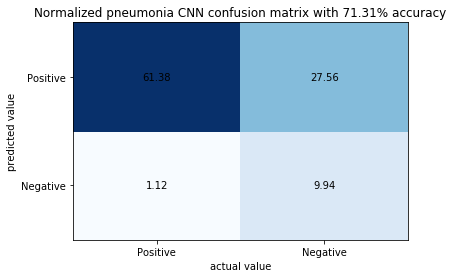

7
624/624 [==============================] - 4s 7ms/sample - loss: 0.7917 - acc: 0.7196


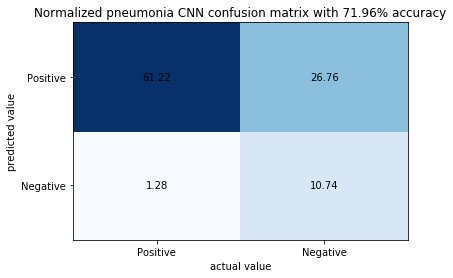

8
624/624 [==============================] - 5s 7ms/sample - loss: 0.7930 - acc: 0.7356


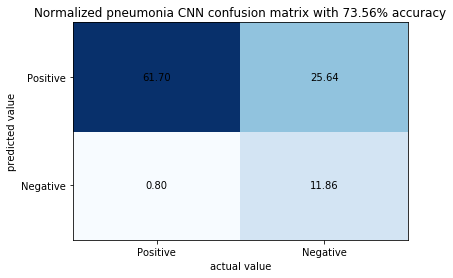

9
624/624 [==============================] - 4s 7ms/sample - loss: 0.8666 - acc: 0.7035


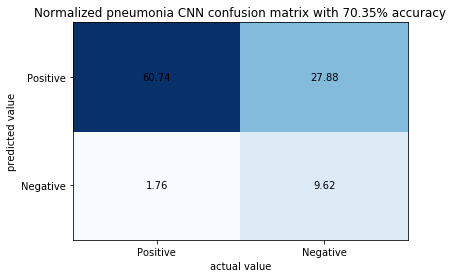

10
624/624 [==============================] - 4s 7ms/sample - loss: 0.8711 - acc: 0.7131


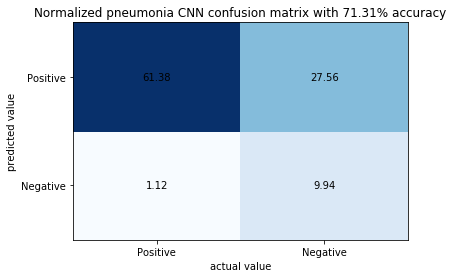

1
624/624 [==============================] - 4s 7ms/sample - loss: 1.3590 - acc: 0.6378


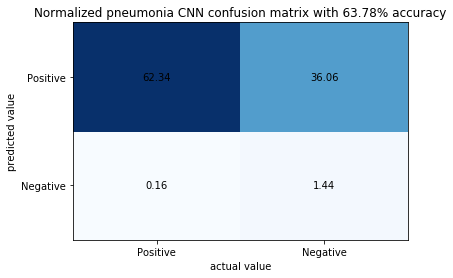

2
624/624 [==============================] - 4s 7ms/sample - loss: 1.3525 - acc: 0.6426


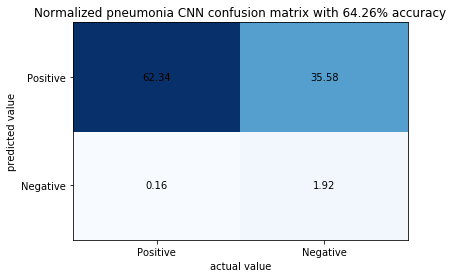

3
624/624 [==============================] - 4s 6ms/sample - loss: 1.3568 - acc: 0.6474


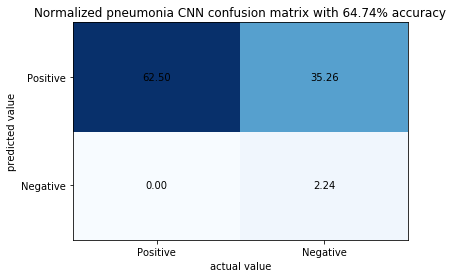

4
624/624 [==============================] - 4s 6ms/sample - loss: 1.3342 - acc: 0.6394


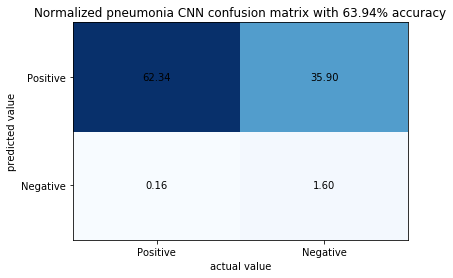

5
624/624 [==============================] - 4s 7ms/sample - loss: 1.3491 - acc: 0.6506


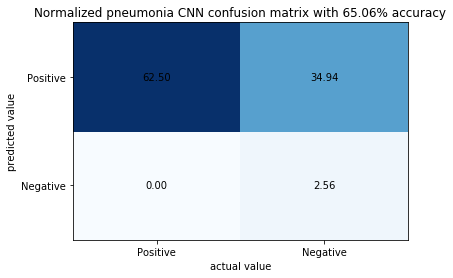

6
624/624 [==============================] - 4s 6ms/sample - loss: 1.3533 - acc: 0.6442


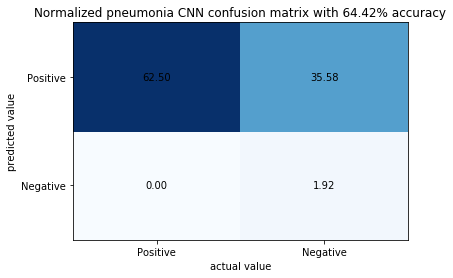

7
624/624 [==============================] - 4s 6ms/sample - loss: 1.3567 - acc: 0.6442 1s - loss: 1.4433 - acc: 


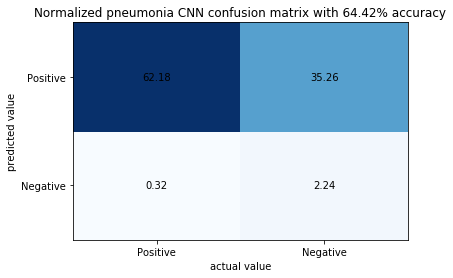

8
624/624 [==============================] - 4s 6ms/sample - loss: 1.3489 - acc: 0.6506


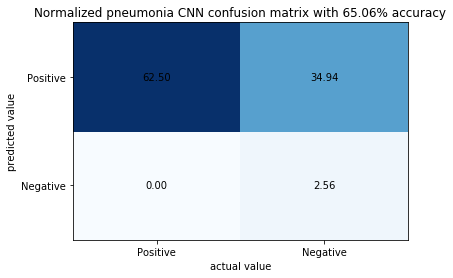

9
624/624 [==============================] - 4s 6ms/sample - loss: 1.3694 - acc: 0.6490


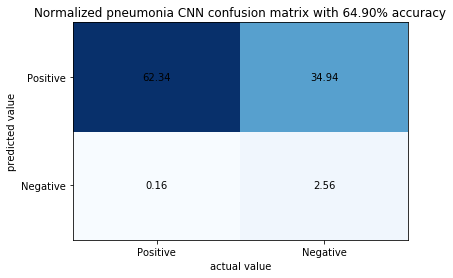

10
624/624 [==============================] - 4s 6ms/sample - loss: 1.3282 - acc: 0.6394


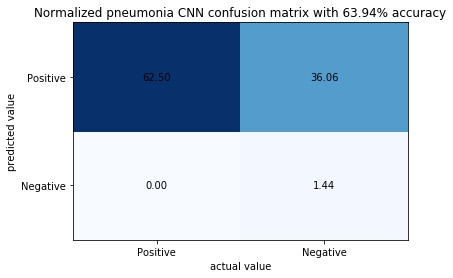

In [7]:
run_id='0005'
num_runs=10
false_negative_0005,false_positive_0005,true_negative_0005,true_positive_0005,accuracy_0005=multiple_running_evaluation_reconst_images(run_id,model,test_features,test_targets,num_runs)
run_id='0006'
false_negative_0006,false_positive_0006,true_negative_0006,true_positive_0006,accuracy_0006=multiple_running_evaluation_reconst_images(run_id,model,test_features,test_targets,num_runs)


In [8]:
mean_acc_0005=np.mean(accuracy_0005)
std_acc_0005=np.std(accuracy_0005)
mean_acc_0006=np.mean(accuracy_0006)
std_acc_0006=np.std(accuracy_0006)


In [9]:
print('mean accuracy 0005:',mean_acc_0005)
print('atd accuracy 0005:',std_acc_0005)
print('mean accuracy 0006:',mean_acc_0006)
print('atd accuracy 0006:',std_acc_0006)

mean accuracy 0005: 0.7176281
atd accuracy 0005: 0.008974357
mean accuracy 0006: 0.6445512
atd accuracy 0006: 0.004521384
